In [1]:
%load_ext autoreload
%autoreload 2

In [71]:
import preprocessing.generate_preprocessed_dataset as pp
import preprocessing.preprocess_data as p
from training.temp_attention_training import run_temp_model_training, create_temporal_pairs, create_dataloaders
from config import Config
import time
import torch
import matplotlib.pyplot as plt
import tqdm
import numpy as np

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [21]:
# X, y, groups, activities = pp.preprocessing(n_epochs=5)

In [22]:
# X.shape, y.shape, groups.shape, activities.shape

In [5]:
start_time = time.time()
loss_dict, best_model = run_temp_model_training(1000)
end_time = time.time()
print(f"Training completed in {(end_time - start_time) / 3600:.2f} hours.")

The device used for training is: cuda
Starting training of split: [ 2 10 15  6]
Starting training of split: [ 5  3  1 12]
Starting training of split: [ 8  4 14 11]
Starting training of split: [ 7  9 13]
Training completed in 2.89 hours.


# Per Activity

In [73]:
activity_dict = {
    0: "Transient",
    1: "Sitting",
    2: "Ascending / Descending Stairs",
    3: "Soccer",
    4: "Cycling",
    5: "Driving Car",
    6: "Lunch",
    7: "Walking",
    8: "Working"
}

# Loss Curves

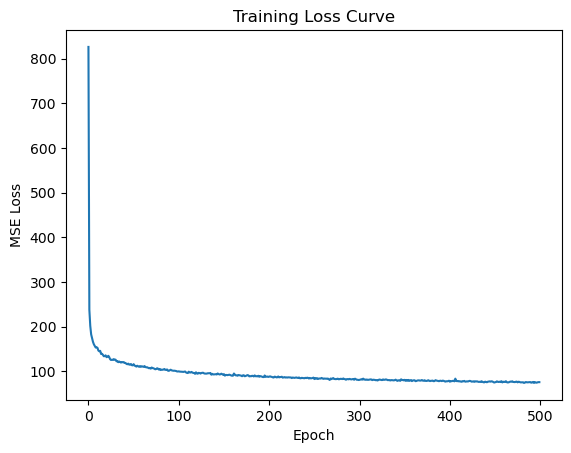

In [68]:
plt.plot(loss_dict[1]["training_loss"])
plt.title("Training Loss Curve")
plt.ylabel("MSE Loss")
plt.xlabel("Epoch")
plt.show()

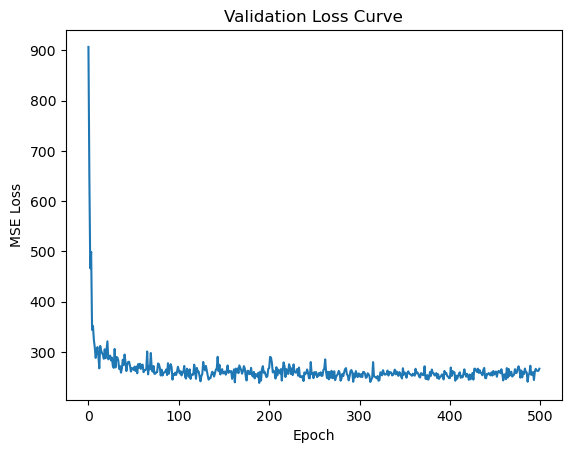

In [69]:
plt.plot(loss_dict[1]["validation_loss_list"])
plt.title("Validation Loss Curve")
plt.ylabel("MSE Loss")
plt.xlabel("Epoch")
plt.show()

In [ ]:
X, y, groups, activity = pp.preprocessing(n_epochs=None)
X = X[:, 0, :]
X, y, groups, activity = create_temporal_pairs(X, y, groups, activity)

In [ ]:
def get_data_loader_by_group_activity(X, y, groups, activities, group, activity):
    X = X[groups == group and activities == activity]
    y = y[groups == group and activities == activity]
    inference_data_loader = create_dataloaders(X, y, batch_size=1)
    return inference_data_loader
    

In [52]:
X, y, groups, activity = pp.preprocessing(n_epochs=None)
X = X[:, 0, :]
X, y, groups, activity = create_temporal_pairs(X, y, groups, activity)
print(X.shape, y.shape, groups.shape, activity.shape)
inference_data_loader = create_dataloaders(X, y, batch_size=1)

(64667, 1, 256, 2) (64667, 1) (64667,) (64667,)


In [72]:
np.unique(activity)

array([0., 1., 2., 3., 4., 5., 6., 7., 8.])

In [67]:
groups

array([ 1,  1,  1, ..., 15, 15, 15])

In [36]:
best_model.eval()
y_truth_arr, y_pred_arr = [], []
with torch.no_grad():
    for X_batch, y_batch in tqdm.tqdm(inference_data_loader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        y_pred = best_model(X_batch[..., 0], X_batch[..., 1])
        y_truth_arr.append(y_batch[0][0].cpu().numpy())
        y_pred_arr.append(y_pred[0][0].cpu().numpy())

100%|██████████| 64667/64667 [06:06<00:00, 176.61it/s]


In [65]:
X_with_ppg, y_ppg, groups_ppg, activity_ppg = p.preprocessing(None, Config())
X_with_ppg.shape

Training data shape: (64682, 4, 256), Test data shape: (64682, 1), Groups shape: (64682,), Activity shape: (64682, 1)


(64682, 4, 256)

In [70]:
X_with_ppg[groups_ppg == 1].shape

(4602, 4, 256)

In [ ]:
plt.plot(X_with_ppg[:])

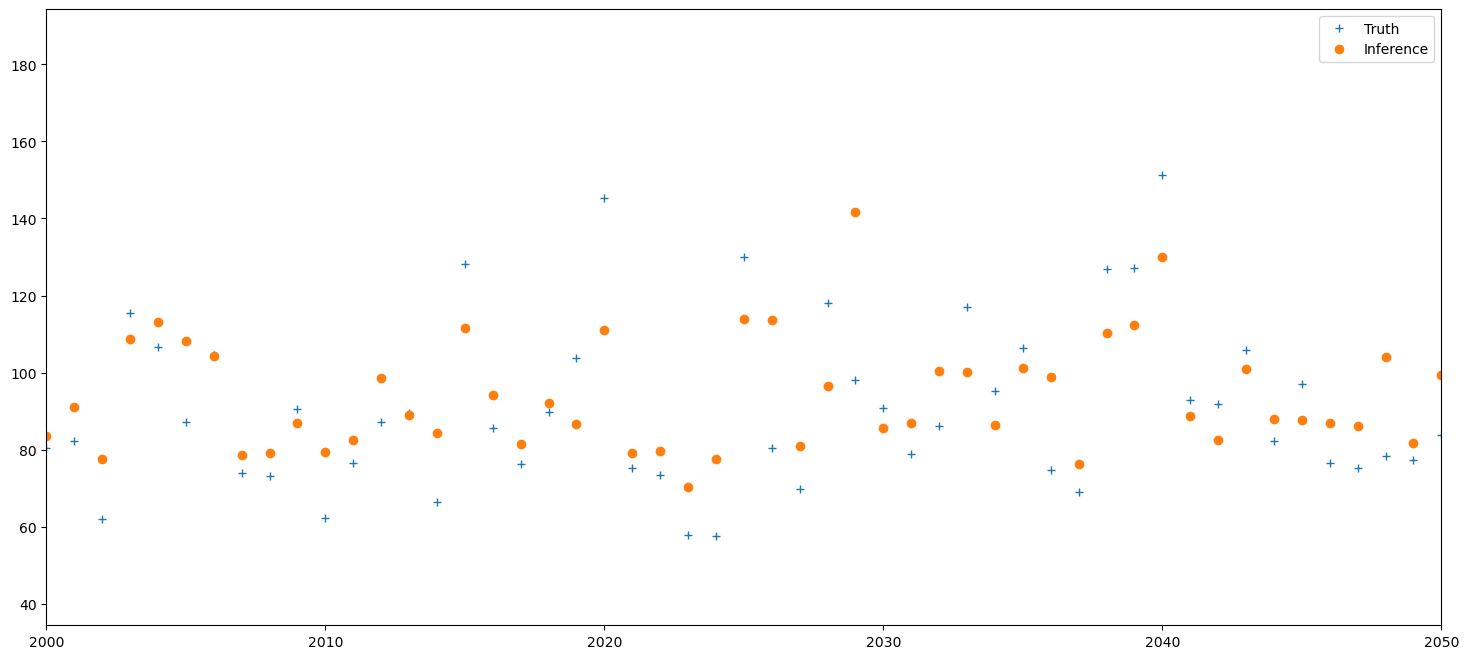

In [61]:
fig = plt.figure(figsize=(18, 8))
plt.plot(y_truth_arr, "+", label = "Truth")
plt.plot(y_pred_arr, "o", label = "Inference")
plt.xlim(2000, 2050)
plt.legend()
plt.show()